# Example-06: FMA

In [1]:
# In this example, a basic application of the Frequency Map Analysis (FMA) indicator is presented

# FMA is based on the idea of (fundamental) frequency array time invariance
# In this method, frequencies are estimated over the first interval and compared with those estimated over the second interval
# For regular initial conditions, one would expect results from different intervals to be close
# For chaotic initial conditions, where, strictly speaking, the frequency is not well defined, the difference will be more notable
# Normally, only two intervals are used for frequency estimation, and the FMA indicator value (sometimes called frequency diffusion) is the log10 of the distance in the frequency space

# FMA is known to be sensitive to both chaotic and strongly nonlinear motion
# Strongly nonlinear motion can still be differentiated from chaotic motion, but this requires more intervals for frequency estimation
# In the case of regular but strongly nonlinear motion, frequencies obtained over different intervals will oscillate around the true frequencies

# Another known problem with FMA is incorrect peak frequency identification
# For nonlinear motion, the amplitude spectrum contains a potentially large number of harmonics
# These harmonics may have similar amplitudes, and frequency estimation procedures might pick different frequencies on different intervals
# This artifact is commonly observed for small horizontal amplitudes and large vertical ones in 4D mappings modeling accelerator lattices
# There is also no guarantee that the fundamental frequency (rather than a harmonic) will be estimated
# To remedy such artifacts, one would need to compute several frequencies at once and perform a type of ordering based on continuity
# This, of course, is computationally more expensive

# Note that the indicator based on the frequency Jacobian does not suffer from the problem of differing frequencies across intervals, as only one interval is used
# However, the computed frequencies are not guaranteed to be fundamental ones

In [2]:
# Import

import numpy

from tqdm import tqdm

import jax
from jax import jit
from jax import vmap

# Test symplectic mapping and corresponding inverse

from tohubohu.util import forward4D

# Frequency factory

from tohubohu import exponential
from tohubohu import frequency

# FMA factory

from tohubohu import fma

# Plotting

from matplotlib import pyplot as plt
from matplotlib import colormaps

cmap = colormaps.get_cmap('viridis')
cmap.set_bad(color='lightgray')

In [3]:
# Set data type

jax.config.update("jax_enable_x64", True)

In [4]:
# Set device

device, *_ = jax.devices('gpu')
jax.config.update('jax_default_device', device)

In [5]:
# Set mapping parameters

nux, nuy = 0.168, 0.201
mux, muy = 2*jax.numpy.pi*nux, 2*jax.numpy.pi*nuy
cx, sx, cy, sy = jax.numpy.cos(mux), jax.numpy.sin(mux), jax.numpy.cos(muy), jax.numpy.sin(muy)
mu = 0.0

k = jax.numpy.asarray([cx, sx, cy, sy, mu])

In [6]:
# Estimate frequeny on several intervals

# Set window

ws = exponential(2**10)

# Set frequency estimator (one interval)

fn = jit(frequency(ws, forward4D, final=True))

# Estimate on a given number of intervals
# Note, this uses a Python loop, this can be also implemented with jax.lax.scan (as it is in fma factory)

length = 2**4
x = jax.numpy.array([0.25, 0.25, 0.0, 0.0])

fs = []
for _ in range(length):
    x, f = fn(x, k)
    fs.append(f)
fs = jax.numpy.stack(fs)

# Set FMA

fn = jit(fma(length, ws, forward4D))

# Estimate and compare frequencies

length = 2**4
x = jax.numpy.array([0.25, 0.25, 0.0, 0.0])

print(fs - fn(x, k))

[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


In [7]:
# Set initial grid in (qx, qy) plane

n = 1001

qx = jax.numpy.linspace(0.0, 0.6, n)
qy = jax.numpy.linspace(0.0, 0.6, n)
qs = jax.numpy.stack(jax.numpy.meshgrid(qx, qy, indexing='ij')).swapaxes(-1, 0).reshape(n*n, -1)
ps = jax.numpy.full_like(qs, 1.0E-12)
xs = jax.numpy.hstack([qs, ps])

In [8]:
# Set indicator

length = 2**1
fn = jit(fma(length, ws, forward4D))

@jit
def gn(x):
    return jax.numpy.log10(1.0E-16 + jax.numpy.sqrt(jax.numpy.sum(jax.numpy.diff(fn(x, k).T)**2)))

out = gn(x)

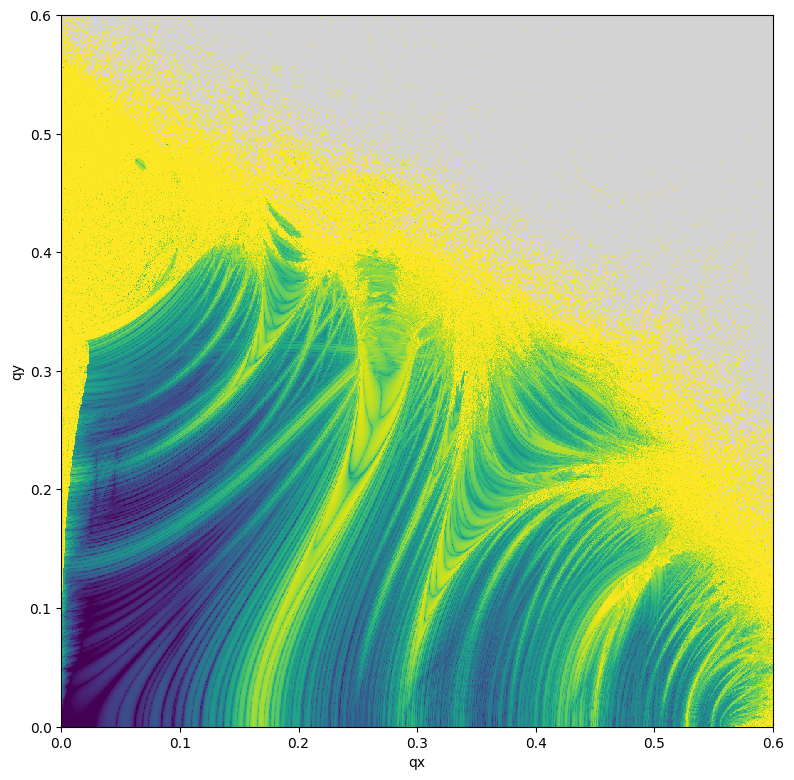

In [9]:
# Evaluate indicator

out = vmap(gn)(xs)

# Winsorize data

data = numpy.array(out)
data[data < -12.0] = -12.0
data[data > -3.0] = -3.0
data = data.reshape(n, n)

# Plot 

plt.figure(figsize=(8, 8))
plt.imshow(data, aspect='equal', vmin=-12.0, vmax=-3.0, origin='lower', cmap=cmap, interpolation='nearest', extent=(0., 0.6, 0., 0.6))
plt.xlabel('qx')
plt.ylabel('qy')
plt.tight_layout()
plt.show()